# RANSAC

<i><b>RANSAC</b></i> - Random sample consensus - итеративный метод оценки параметров математической модели на основе случайных выборок. Основным свойством RANSAC является устойчивость к данным, содержащим выбросы ("outliers"). 

Данный алгоритм был придуман и впервые опубликован Мартином Фишлером и Робертом Боллесом в статье <i>"Random Sample Consensus: A Paradigm for Model Fitting with Applications to Image Analysis and Automated Cartography"</i> в июне 1981 года.

## Обзор

### Мотивация

На практике достаточно часто возникают задачи обработки данных, когда необходимо подбирать параметры математических моделей, которые должны удовлетворять исходным данным. Исходные данные, интуитивно, можно разделить на 2 типа:
<ul>
    <li>"хорошие" точки - <i>inliers</i> - точки, которые удовлетворяют модели;</li>
    <li>"плохие" точки - <i>outliers</i> - точки, которые находятся далеко от построенной модели, случайные точки, ложные данные, шумы и т.д.</li>
</ul>

Сгенерируем пример.

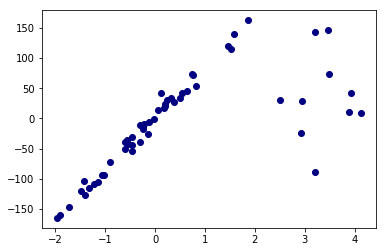

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Зададим кол-во примерных точек
n_samples = 45
n_outliers = 10

# Построим модельный датасет
X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    noise=10,
    coef=True,
    random_state=42
)

# Пошумим!
rng = np.random.RandomState(0)
X_outliers = 3 + 0.5 * rng.normal(size=(n_outliers, 1))
y_outliers = -3 + 100 * rng.normal(size=n_outliers)
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

# Нарисуем!
plt.scatter(X, y, c="navy")
plt.show()

В этом примере явно видна линия, но есть и плохие точки. В принципе, почему бы не попробовать построить линейную регрессию?

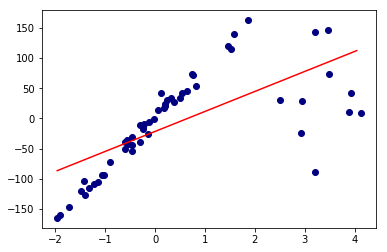

In [2]:
from sklearn import linear_model

# Построим линейную регрессию, тут у нас метод наименьших квадратов.
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, y)

# Нарисуем то, что получили в результате.
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lin_reg.predict(line_X)

plt.scatter(X, y, c="navy")
plt.plot(line_X, line_y, color="red")
plt.show()


<img src="image.jpg" style="width: 250px;"/>


Кажется, что-то пошло не так. 

Дело в том, что метод наименьших квадратов оттянул нашу линию вправо, т.к расстояние (вернее, сумма квадратов расстояний) между линией, которую хотелось бы получить нам, и плохими точками оказалось больше, чем в том варианте, который мы получили. 

Попытаемся решить эту проблему.

### Предположения

RANSAC предполагает, что обучающие данные содержат <i>inliers</i>, которые будут предсказываться моделью, и <i>outliers</i>, которые являются ошибочными для модели. Обучение на "плохих" данных будет только увеличивать ошибку в итоговой модели. Поэтому RANSAC пытается определять, где находятся эти "плохие" данные и обучается только на "хороших" данных.  

На каждом шаге своей работы RANSAC делает грубое предположение о разделении данных. Но даже если это предположение не выполнится, RANSAC не принесёт вреда оценке параметров, потому что он рассматривает всевозможные разделения на inliers и outliers и выбирает лучшее предположение. 

### Описание метода

Метод случайным образом выбирает подмножество исходных данных и использует его для построения модели. Затем, используя порог ошибки (<i>error tolerance</i>), он определяет, какие данные являются хорошими, а какие - плохими. Мощность подмножества хороших данных (количество точек), которые были выбраны на итерации алгоритма, называются <i>консенсусом</i> модели. Наша цель - максимизация консенсуса, т.е максимизация мощности подмножества хороших данных. 

RANSAC <u>не гарантирует</u> достижения оптимума, а даёт приблизительную оценку. Но, вероятность того, что оптимум не будет найден, крайне мала. 

### Алгоритм

Реализуем данный алгоритм. Рассмотрим только случай линейной модели.

In [3]:
class LinearRANSAC:
    """
        Класс с реализацией алгоритма RANSAC для построения линейной модели.
    """
    
    
    def __init__(self, **params):
        """
        Конструктор класса
        :param iterations: максимальное кол-во итераций. 20 по умолчанию
        :param dist_threshold: порог расстояния от точки данных до построенной модели
        """
        self.iterations = params.get("iterations", 20)
        self.dist_threshold = params.get("dist_threshold", 10.0)
        
        self._param1 = 0
        self._param2 = 0
        self._best_inliers = []
        self._best_outliers = []
    
    
    def _euclid(self, A, B):
        """
        Эвклидово расстояние между двумя точками.
        """
        return np.sqrt(np.sum(np.power(A - B, 2)))
    
    def predict(self, X):
        """
        Функция предсказывания. 
        """
        return self._param1 * X + self._param2
    
    def get_inliers(self):
        """
        Получить список inliers.
        """
        return self._best_inliers
    
    def get_outliers(self):
        """
        Получить список outliers.
        """
        return self._best_outliers
    
    def fit(self, X, y):
        """
        Обучиться на данных.
        :param X:  - np.array c X.shape = (55, 1)
        :param y:  - np.array c y.shape = (55,)
        """
        
        # Количество экземпляров в данных.
        number_of_samples, _ = X.shape
        
        # Наибольшее количесвто inliers
        best_consensus = 0
        
        for i in range(self.iterations):
            # Выберем случайным образом 2 точки. Нам их достаточно для построения линейной модели.
            idx1, idx2 = np.random.randint(0, high=number_of_samples-1, size=2)
            
            sample1 = np.array([X[idx1][0], y[idx1]])
            sample2 = np.array([X[idx2][0], y[idx2]])
            
            # Сделаем линию. Строим модель. 
            # y = mx + c -> m = (y2-y1)/(x2-x1), c = y2 - mx2
            m = (sample2[1] - sample1[1])/(sample2[0] - sample1[0])
            c = sample2[1] - m * sample2[0]
            
            get_line_y = lambda m, c, x: m*x + c
            
            # Подсчитаем расстояния
            # Для этого нам надо найти расстояние от точки на модели до точки наших изначальных данных
            inliers = []
            outliers = []
            for i in range(number_of_samples):
                curr_point_data = np.array([X[i][0], y[i]])
                curr_point_on_model = np.array([X[i][0], get_line_y(m, c, X[i][0])])
                
                dist = self._euclid(curr_point_data, curr_point_on_model)
                
                # Если расстояние меньше порога, то это inlier
                if dist <= self.dist_threshold:
                    inliers.append(curr_point_data)
                else:
                    outliers.append(curr_point_data)
            
            # Сохраняем лучший результат.
            count_inliers = len(inliers)
            if count_inliers > best_consensus:
                best_consensus = count_inliers
                self._param1 = m
                self._param2 = c
                self._best_inliers = inliers
                self._best_outliers = outliers
            
            
        
        
        
                

Вроде как, написали. Посмотрим, что из этого получится.

## Тестирование

Запустим RANSAC на наших данных. Можем позапускать его с разными параметрами. Также, нарисуем то, что RANSAC посчитал outliers и inliers. 

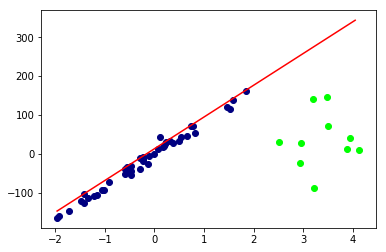

In [4]:
c = LinearRANSAC(iterations = 30, dist_threshold = 35)
c.fit(X, y)

# Нарисуем то, что получили в результате.
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = c.predict(line_X)

inl = c.get_inliers()
outl = c.get_outliers()

show_inliers_X = [x[0] for x in inl]
show_inliers_y = [x[1] for x in inl]
show_outliers_X = [x[0] for x in outl]
show_outliers_y = [x[1] for x in outl]

plt.scatter(show_inliers_X, show_inliers_y, c="navy")
plt.scatter(show_outliers_X, show_outliers_y, c="lime")
plt.plot(line_X, line_y, color="red")
plt.show()

Ого! Выглядит лучше, чем было. Модель уже похожа на правдоподобную. Группа с outliers выделилась хорошо. Интересно сможет ли с одного раза построить?

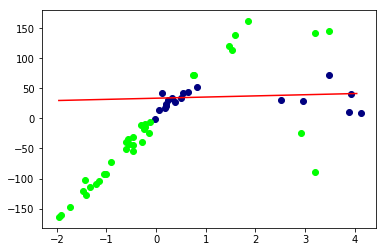

In [9]:
c = LinearRANSAC(iterations = 1, dist_threshold = 35)
c.fit(X, y)

# Нарисуем то, что получили в результате.
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = c.predict(line_X)

inl = c.get_inliers()
outl = c.get_outliers()

show_inliers_X = [x[0] for x in inl]
show_inliers_y = [x[1] for x in inl]
show_outliers_X = [x[0] for x in outl]
show_outliers_y = [x[1] for x in outl]

plt.scatter(show_inliers_X, show_inliers_y, c="navy")
plt.scatter(show_outliers_X, show_outliers_y, c="lime")
plt.plot(line_X, line_y, color="red")
plt.show()

Не, не сможет. Вернее не так: не всегда построит. В зависимости от того, как выберет начальные точки. Вот и недостаток обнаружился: мы не знаем, сколько итераций должно быть, чтобы отыскать оптимум.

<b>Достоинства алгорима:</b>
<ul>
    <li>умеет отбрасывать выбросы в данных</li>
    <li>достаточно общий метод, который можно применить в большинстве случаев</li>
    <li>достаточно быстрый алгоритм - работает за $O(iterations * |D|)$ для линейного случая</li>
    <li>прост в реализации</li>
</ul>

<b>Недостатки алгорима:</b>
<ul>
    <li>не всегда получаем точный ответ</li>
    <li>требует предварительных знаний о данных</li>
    <li>количество итераций будет возрастать логарифмически, если мы будем увеличивать количество outliers</li>
</ul>

## Модификации RANSAC

<ol>
    <li><i>MLESAC</i> - модификация, в которой максимизируется вероятность того,что данные были сгенерированы какой-то другой моделью, например смешанной моделью inliers и outliers </li>
    <li><i>MAPSAC</i> - расширение для MLESAC</li>
    <li><i>KALMANSAC</i> - нечто очень интересное, неочевидное, в меру сложное, скрывающееся под девизом "причинный вывод состояния динамической модели, в которой измерения повреждены выбросами". Здесь можно узнать более подробно. <a href="https://www.researchgate.net/publication/4193886_KALMANSAC_robust_filtering_by_consensus">Тык!</a></li>
</ol>

## Применения RANSAC

RANSAC очень часто используется в компьютерном зрениив задачах стабилизации видео. Идея состоит в следующем: существуют алгоритмы, которые способны найти некоторые признаки на каждой из картинок (кадров видео) (см. SIFT, SURF, FAST). По этим признакам нам необходимо построить преобразование между двумя картинками таким образом, чтобы 
это преобразование минимизировало проекционную ошибку после проектирования точек одного изображения на точки другого. Проще говоря, нам надо наложить одну картинку на другую с максимальным соответствием, чтобы камера не дрыгалась :) Стоит заметить, что если посмотреть на эти признаки, то можно заметить большое количесвто выбросов.
<br>
Тут RANSAC и приходит на помощь. Он выбирает подмножество признаков таким образом, чтобы минимизировать проекционную ошибку. Таким образом, из расположения признаков, мы можем оценить наилучшие параметры преобразования.